# Motor Fault Classification

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.fft import fft
from scipy.stats import kurtosis, skew
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


### Global Parameters

In [2]:
FS = 750
DURATION = 1.0
TIME = np.linspace(0, DURATION, int(FS * DURATION))
BASE_FREQ = 50

WINDOW_SIZE = 500
STEP_SIZE = 250
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


### Motor Signal Generator Class

In [3]:
class MotorSignalGenerator:
    def __init__(self, t, base_freq):
        self.t = t
        self.base_freq = base_freq

    def healthy(self):
        return np.sin(2 * np.pi * self.base_freq * self.t)

    def bearing_fault(self, severity):
        return self.healthy() + severity * np.sin(2 * np.pi * 300 * self.t) + 0.05 * np.random.randn(len(self.t))

    def rotor_fault(self, severity):
        return self.healthy() * (1 + severity * np.sin(2 * np.pi * 5 * self.t))

    def stator_fault(self, severity):
        return self.healthy() + severity * np.random.randn(len(self.t))

    def apply_load_variation(self, signal):
        return signal * (1 + 0.2 * np.sin(2 * np.pi * 2 * self.t))


### Feature Extractor Class

In [4]:
class FeatureExtractor:
    def __init__(self, fs):
        self.fs = fs

    def extract(self, signal):
        N = len(signal)
        fft_vals = np.abs(fft(signal))[:N//2]
        freqs = np.fft.fftfreq(N, 1/self.fs)[:N//2]

        return {
            "rms": np.sqrt(np.mean(signal**2)),
            "mean": np.mean(signal),
            "variance": np.var(signal),
            "peak": np.max(np.abs(signal)),
            "skewness": skew(signal),
            "kurtosis": kurtosis(signal),
            "dominant_freq": freqs[np.argmax(fft_vals)],
            "spectral_energy": np.sum(fft_vals**2),
            "band_low": np.sum(fft_vals[(freqs < 100)]**2),
            "band_mid": np.sum(fft_vals[(freqs >= 100) & (freqs < 500)]**2),
            "band_high": np.sum(fft_vals[(freqs >= 500)]**2)
        }


### Dataset Builder

In [5]:
def build_dataset(generator, extractor, samples=40):
    X, y = [], []

    for _ in range(samples):
        signals = {
            "Healthy": generator.healthy(),
            "Bearing": generator.bearing_fault(np.random.uniform(0.3, 0.7)),
            "Rotor": generator.rotor_fault(np.random.uniform(0.2, 0.5)),
            "Stator": generator.stator_fault(np.random.uniform(0.3, 0.6))
        }

        for label, sig in signals.items():
            sig = generator.apply_load_variation(sig)
            feats = extractor.extract(sig)
            X.append(list(feats.values()))
            y.append(label)

    return np.array(X), np.array(y), list(feats.keys())


### FFT Plot Function

In [6]:
def plot_fft(signal, title):
    N = len(signal)
    fft_vals = np.abs(fft(signal))[:N//2]
    freqs = np.fft.fftfreq(N, 1/FS)[:N//2]

    plt.plot(freqs, fft_vals)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()


### Generate Signals

In [7]:
generator = MotorSignalGenerator(TIME, BASE_FREQ)
extractor = FeatureExtractor(FS)

signals = {
    "Healthy": generator.healthy(),
    "Bearing": generator.bearing_fault(0.5),
    "Rotor": generator.rotor_fault(0.4),
    "Stator": generator.stator_fault(0.5)
}


### Time-Domain Comparison

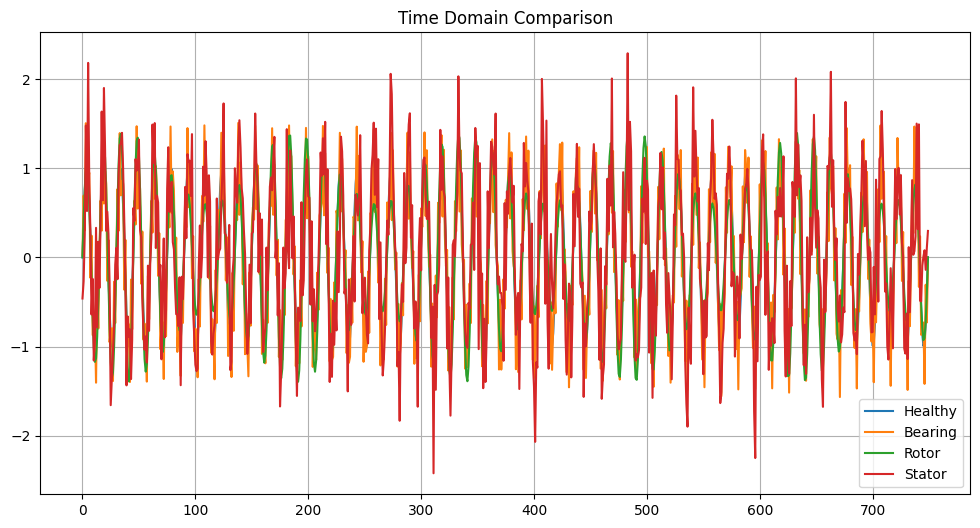

In [8]:
plt.figure(figsize=(12,6))
for k, v in signals.items():
    plt.plot(v[:1000], label=k)

plt.title("Time Domain Comparison")
plt.legend()
plt.grid()
plt.show()


### FFT Comperation

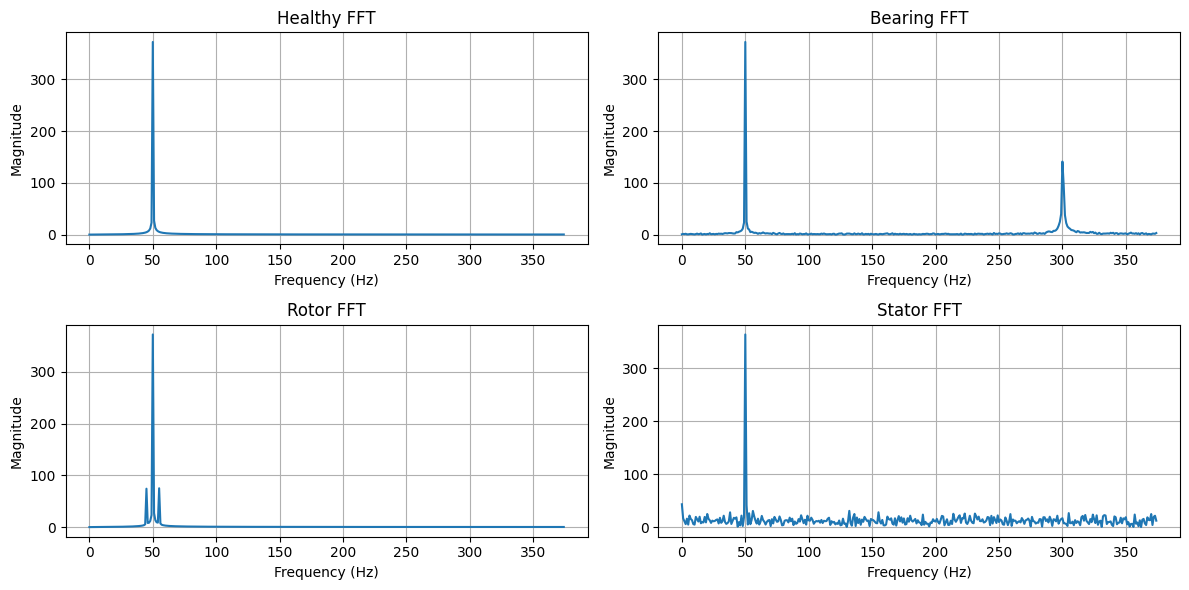

In [9]:
plt.figure(figsize=(12,6))

plt.subplot(2,2,1); plot_fft(signals["Healthy"], "Healthy FFT")
plt.subplot(2,2,2); plot_fft(signals["Bearing"], "Bearing FFT")
plt.subplot(2,2,3); plot_fft(signals["Rotor"], "Rotor FFT")
plt.subplot(2,2,4); plot_fft(signals["Stator"], "Stator FFT")

plt.tight_layout()
plt.show()


### Feature Comparison

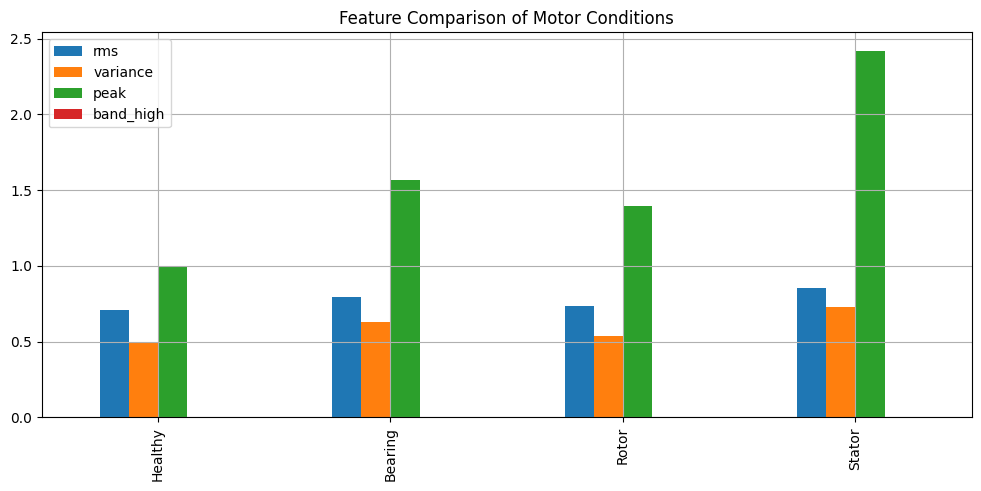

In [10]:
feature_data = {k: extractor.extract(v) for k, v in signals.items()}
df_feat = pd.DataFrame(feature_data)

df_feat.T[["rms","variance","peak","band_high"]].plot(
    kind="bar", figsize=(12,5)
)

plt.title("Feature Comparison of Motor Conditions")
plt.grid()
plt.show()


### Machine Learning (KNN)

In [11]:
X, y, feature_names = build_dataset(generator, extractor)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

preds = model.predict(X_test)


### Results

In [12]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test, preds))

print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, preds))


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

     Bearing       1.00      1.00      1.00         9
     Healthy       1.00      1.00      1.00        13
       Rotor       1.00      1.00      1.00        15
      Stator       1.00      1.00      1.00        11

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

CONFUSION MATRIX:

[[ 9  0  0  0]
 [ 0 13  0  0]
 [ 0  0 15  0]
 [ 0  0  0 11]]
